<a href="https://colab.research.google.com/github/sanskruti0ise/fin_news_sentiment/blob/main/finance_news_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Finance News Sentimental Analysis**

**Task 1: Data Collection and Preprocessing**

Used the following commands on terminal:
* Merged all the necessary files into one :  **cat ./* > merged-file.txt**
* Removed Duplicates : **sort  --random-sort -u merged-file.txt > sorted-unique.txt**
* Converted the text file to csv with '@' as delimiter for ease:

                    import pandas as pd
                    account = pd.read_csv("sorted-unique.txt", delimiter = '@', encoding="ISO-8859-1")
                    account.to_csv('fin.csv', header=['news_article','sentiment'])  



**Download the csv file from drive link**

In [1]:
import gdown

file_id = '1C-OVF0h-YU5npLTG95qIU6Di71hYUZhJ'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'fin.csv'  # Change this to your desired file name and extension
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1C-OVF0h-YU5npLTG95qIU6Di71hYUZhJ
To: /content/fin.csv
100%|██████████| 694k/694k [00:00<00:00, 29.2MB/s]


'fin.csv'

**Installation and Imports**

In [2]:
!pip install transformers
!pip install datasets
!pip install --upgrade pyarrow

In [3]:
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, DistilBertTokenizerFast,DistilBertForSequenceClassification
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import Counter, defaultdict
import torch
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score
import warnings
warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
#Setting and Checking GPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Load the dataset and perform an initial exploration.**

Initial CSV file looks like:

In [5]:
fin_file = "/content/fin.csv"
data = pd.read_csv(fin_file)
data.drop('Unnamed: 0', axis=1, inplace=True)

data.drop(data.filter(regex="Unnamed"),axis=1, inplace=True)
data

,news_article,sentiment
0,Finnish investment group Norvestia Oyj said it...,negative
1,The total emissions reduction from 1999 to 201...,neutral
2,Technopolis has approximately 130 customer com...,neutral
3,The liquidity providing was interrupted on May...,negative
4,27 January 2011 - Finnish IT solutions provide...,positive
...,...,...
4834,"The price of the 10,000 kroon par value bonds ...",neutral
4835,The measures result from weak demand in the sh...,negative
4836,As production of other products will continue ...,negative
4837,The maritime administration said the ships had...,negative


In [6]:
data.shape

(4839, 2)

To check if any value is empty.:

In [7]:
data.isna().sum()

news_article    0
sentiment       0
dtype: int64

Percentage of each sentiment in the data

In [8]:
data.sentiment.value_counts()/data.shape[0]

sentiment
neutral     0.593511
positive    0.281670
negative    0.124819
Name: count, dtype: float64

[Text(0, 0, '2872'), Text(0, 0, '1363'), Text(0, 0, '604')]

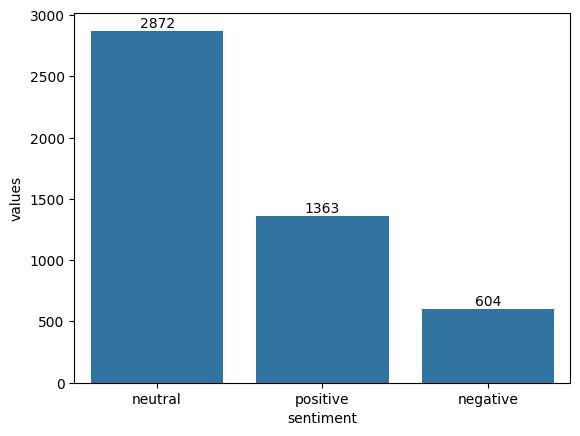

In [9]:
counts = data['sentiment'].value_counts().rename_axis('sentiment').reset_index(name='values')

ax = sns.barplot(x='sentiment', y='values', data=counts)
ax.bar_label(ax.containers[0])

**Preprocess the text data to remove noise, such as punctuation and stopwords, and perform
tokenization.**

In [10]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def cleaning_data(text):
  text = str(text).lower()
  text = text.replace('{html}', "")
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', text)
  rem_url=re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  stem_words=[stemmer.stem(w) for w in filtered_words]
  lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
  return " ".join(filtered_words)
data['news_article']=data['news_article'].map(lambda s:cleaning_data(s))

In [11]:
def ngrams(input, n):
    output = []
    for i in range(len(input)-n+1):
        output.append('_'.join(input[i:i+n]))
    return output

In [12]:
nltk.download('punkt')
tags = ['neutral','negative','positive']

df = data[data.sentiment.isin(tags)]
df['Tokens'] = df.apply(lambda row: nltk.word_tokenize(row['news_article'].strip()), axis=1)
df['bi_Grams']  = df.apply(lambda row: ngrams(row['Tokens'], 2), axis=1)
df['tri_Grams']  = df.apply(lambda row: ngrams(row['Tokens'], 3), axis=1)
print(len(df),'samples from',len(tags),'classes')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


4839 samples from 3 classes


In [13]:
c_unique = Counter()
for ind in df.index:
    c_unique.update(Counter(set(df.loc[ind]['Tokens'])))

print('First 20 common words:\n')
for word in c_unique.most_common(20):
    print(word[0],'-->', 'appeared in',word[1],'documents out of {} documents i.e.'.format(len(df)),np.round(100*word[1]/len(df),2),'%')

First 20 common words:

eur --> appeared in 801 documents out of 4839 documents i.e. 16.55 %
company --> appeared in 799 documents out of 4839 documents i.e. 16.51 %
said --> appeared in 543 documents out of 4839 documents i.e. 11.22 %
finnish --> appeared in 512 documents out of 4839 documents i.e. 10.58 %
sales --> appeared in 428 documents out of 4839 documents i.e. 8.84 %
profit --> appeared in 406 documents out of 4839 documents i.e. 8.39 %
net --> appeared in 384 documents out of 4839 documents i.e. 7.94 %
year --> appeared in 341 documents out of 4839 documents i.e. 7.05 %
finland --> appeared in 330 documents out of 4839 documents i.e. 6.82 %
million --> appeared in 311 documents out of 4839 documents i.e. 6.43 %
group --> appeared in 302 documents out of 4839 documents i.e. 6.24 %
operating --> appeared in 294 documents out of 4839 documents i.e. 6.08 %
new --> appeared in 261 documents out of 4839 documents i.e. 5.39 %
business --> appeared in 251 documents out of 4839 docume

In [14]:
sent = data.sentiment.unique()
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)
data['label'] = data.sentiment.replace(label)
data.head()

,news_article,sentiment,label
0,finnish investment group norvestia oyj said ne...,negative,0
1,total emissions reduction thus,neutral,1
2,technopolis approximately customer companies j...,neutral,1
3,liquidity providing interrupted may aspocomp g...,negative,0
4,january finnish solutions provider affecto oyj...,positive,2


In [15]:
df_temp, df_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=42, stratify=df_temp['sentiment'])


In [16]:
print("size of training set : " + str(df_train.shape[0]))
print("size of validation set : " + str(df_val.shape[0]))
print("size of test set : " + str(df_test.shape[0]))

size of training set : 3483
size of validation set : 388
size of test set : 968


In [17]:
from sklearn.utils import resample

sentiment = data.sentiment.unique()
max = 2
target_majority = data[data.sentiment==sentiment[max]]


for cl in range(3):
    train_minority = df_train[df_train.sentiment==sentiment[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=33)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=max:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts()

sentiment
neutral     1363
negative    1363
positive    1363
Name: count, dtype: int64

#**Model list**
*  **DistilBERT : distilbert-base-uncased : 0**
*  **TinyBERT : Intel/dynamic_tinybert : 1**
*  **MiniLM  : microsoft/MiniLM-L12-H384-uncased : 2**

In [18]:
model_list = ["distilbert-base-uncased", "Intel/dynamic_tinybert", "microsoft/MiniLM-L12-H384-uncased"]

Select 0/1/2 according to Model List

In [19]:
model = BertForSequenceClassification.from_pretrained(model_list[0],num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_list[0])

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

In [20]:
from datasets import Dataset
dataset_train = Dataset.from_pandas(train_upsampled)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['news_article'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['news_article'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['news_article'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/4089 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/968 [00:00<?, ? examples/s]

In [21]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

In [22]:
args = TrainingArguments(
        output_dir = 'output/',
        evaluation_strategy="steps",
        num_train_epochs=5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs_dir',
        #logging_steps=10,
        load_best_model_at_end=True,
)

In [23]:
trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dataset_train,
        eval_dataset=dataset_val,
        compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.874600,1.818215,0.435567


TrainOutput(global_step=640, training_loss=0.7641700565814972, metrics={'train_runtime': 427.2233, 'train_samples_per_second': 47.856, 'train_steps_per_second': 1.498, 'total_flos': 1344838456362240.0, 'train_loss': 0.7641700565814972, 'epoch': 5.0})

In [24]:
model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 1.872642993927002,
 'test_accuracy': 0.42045454545454547,
 'test_runtime': 6.6783,
 'test_samples_per_second': 144.948,
 'test_steps_per_second': 2.396}

In [25]:
preds = trainer.predict(dataset_test)

In [26]:
probs = torch.from_numpy(preds[0]).softmax(1)
predictions = probs.numpy()# convert tensors to numpy array

new_df = pd.DataFrame(predictions,columns=data.sentiment.unique())
new_df.head()

,negative,neutral,positive
0,0.137640,0.827972,0.034388
1,0.034327,0.064596,0.901077
2,0.052837,0.659223,0.287939
3,0.936654,0.031334,0.032012
4,0.879761,0.007288,0.112951


In [27]:
df_test_distil_bert = df_test.copy()

results = np.argmax(predictions,axis=1)

df_test_distil_bert['Sentiment_pred'] = results
df_test_distil_bert['Sentiment_pred'] = df_test_distil_bert['Sentiment_pred']
df_test_distil_bert['label_pred'] = results


emotion = {0: 'negative', 1: 'neutral', 2: 'positive'}
df_test_distil_bert['Sentiment_pred'] = df_test_distil_bert['Sentiment_pred'].map(emotion )

df_test_distil_bert.head()

,news_article,sentiment,label,Sentiment_pred,label_pred
2588,exel headquartered mantyharju finland,neutral,1,neutral,1
4471,beyond improved voice capabilities customers s...,positive,2,positive,2
2184,expo signature show dongguan supported donggua...,neutral,1,neutral,1
2453,yvonne jones owner chameleon interiors,neutral,1,negative,0
899,also lemmink ñinen profit accounting period we...,positive,2,negative,0


In [28]:
print('Classification_report of', model_list[0], 'Model:')

print(classification_report(df_test_distil_bert['sentiment'], df_test_distil_bert['Sentiment_pred']))

Classification_report of distilbert-base-uncased Model:
              precision    recall  f1-score   support

    negative       0.18      0.95      0.31       121
     neutral       0.90      0.37      0.53       574
    positive       0.72      0.28      0.41       273

    accuracy                           0.42       968
   macro avg       0.60      0.54      0.41       968
weighted avg       0.76      0.42      0.47       968



In [29]:
!pip install flask
!pip install flask-ngrok
!pip install pyngrok

In [47]:
!ngrok authtoken 2kKfyEEqxBYAVnkANqpYevnqMyz_5dE1E4fRGnC4H3i8kVfX4

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [48]:
from pyngrok import ngrok
public_url = ngrok.connect(5000)
print(public_url)

NgrokTunnel: "https://e8f2-34-23-28-188.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
from flask import Flask, request, jsonify
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from flask_ngrok import run_with_ngrok
import logging

# Initialize Flask app
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

# Setup logging
logging.basicConfig(level=logging.DEBUG)

# Load the fine-tuned model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained('/content/output/checkpoint-640', local_files_only=True)

# Define a function to preprocess and predict the sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    sentiment = ['negative', 'neutral', 'positive'][prediction]
    return sentiment

# Define the root endpoint
@app.route('/')
def home():
    return "Welcome to the Sentiment Analysis API. Use the /predict endpoint to get predictions."

# Define the predict endpoint
@app.route('/predict', methods=['GET', 'POST'])
def predict():
    try:
        data = request.get_json()
        app.logger.debug("Received data: %s", data)
        if 'text' not in data:
            return jsonify({'error': 'No text field provided'}), 400
        text = data['text']
        sentiment = predict_sentiment(text)
        return jsonify({'sentiment': sentiment})
    except Exception as e:
        app.logger.error("Error occurred: %s", str(e))
        return jsonify({'error': str(e)}), 500

# Run the Flask app
if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://e8f2-34-23-28-188.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [07/Aug/2024 14:52:57] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Aug/2024 14:52:58] "GET /favicon.ico HTTP/1.1" 404 -
ERROR:__main__:Error occurred: 415 Unsupported Media Type: Did not attempt to load JSON data because the request Content-Type was not 'application/json'.
INFO:werkzeug:127.0.0.1 - - [07/Aug/2024 14:53:04] "GET /predict HTTP/1.1" 500 -
ERROR:__main__:Error occurred: 415 Unsupported Media Type: Did not attempt to load JSON data because the request Content-Type was not 'application/json'.
INFO:werkzeug:127.0.0.1 - - [07/Aug/2024 14:54:22] "GET /predict HTTP/1.1" 500 -
ERROR:__main__:Error occurred: 415 Unsupported Media Type: Did not attempt to load JSON data because the request Content-Type was not 'application/json'.
INFO:werkzeug:127.0.0.1 - - [07/Aug/2024 14:54:53] "GET /predict HTTP/1.1" 500 -
INFO:werkzeug:127.0.0.1 - - [07/Aug/2024 14:56:31] "POST /predict HTTP/1.1" 200 -
